## "Data Grabber" for quantative analysis of stocks
---

**Created By Paras Patange**


**Goal:** To create a grabber tool which will grab data from the web and create a CSV file which can be read to do analysis.

**Enter Discussion Partner IDs Below:**
You could add more IDs with the same markdown format above.

**Import Statements:**

In [1]:
import datetime
import yfinance as yf
import pandas as pd
import pandas as pd
import numpy as np
from scipy.stats import norm

Small Test If Data Can be Grabbed

In [2]:
# Define the stock tickers and time period
tickers = [ "AAPL","AMZN", "TSLA", "GOOGL", "MSFT" ]
#"AMZN", "TSLA" "GOOGL", "MSFT"
start_date = "2023-05-01"
end_date = "2023-12-04"

# Fetch historical stock prices
data = yf.download(tickers, start=start_date, end=end_date)

# Display the first few rows of the data
print(data.head())
print("LENGTH IS",len(data))


[*********************100%%**********************]  5 of 5 completed
             Adj Close                                                  \
                  AAPL        AMZN       GOOGL        MSFT        TSLA   
Date                                                                     
2023-05-01  168.904831  102.050003  107.199997  303.633057  161.830002   
2023-05-02  167.859070  103.629997  105.320000  303.483978  160.309998   
2023-05-03  166.773483  103.650002  105.410004  302.480377  160.610001   
2023-05-04  165.120178  104.000000  104.690002  303.483978  161.199997   
2023-05-05  172.868774  105.660004  105.570000  308.690979  170.059998   

                 Close                                                  ...  \
                  AAPL        AMZN       GOOGL        MSFT        TSLA  ...   
Date                                                                    ...   
2023-05-01  169.589996  102.050003  107.199997  305.559998  161.830002  ...   
2023-05-02  168.539993

If unstacked dataframe is required, run the following:

In [93]:
# Unstack the multi-level columns
df_unstacked = data.stack(level=0)

# Display the unstacked dataframe
print(df_unstacked)

                              AAPL          AMZN          MSFT  TSLAGOOGL
Date                                                                     
2023-05-01 Adj Close  1.689048e+02  1.020500e+02  3.036331e+02        NaN
           Close      1.695900e+02  1.020500e+02  3.055600e+02        NaN
           High       1.704500e+02  1.052300e+02  3.086000e+02        NaN
           Low        1.686400e+02  1.018200e+02  3.051500e+02        NaN
           Open       1.692800e+02  1.049500e+02  3.069700e+02        NaN
...                            ...           ...           ...        ...
2023-11-22 Close      1.913100e+02  1.467100e+02  3.778500e+02        NaN
           High       1.929300e+02  1.477400e+02  3.797900e+02        NaN
           Low        1.908300e+02  1.445700e+02  3.749700e+02        NaN
           Open       1.914900e+02  1.445700e+02  3.780000e+02        NaN
           Volume     3.961770e+07  4.566910e+07  2.334530e+07        NaN

[864 rows x 4 columns]


Visualise the data with matplotlib:

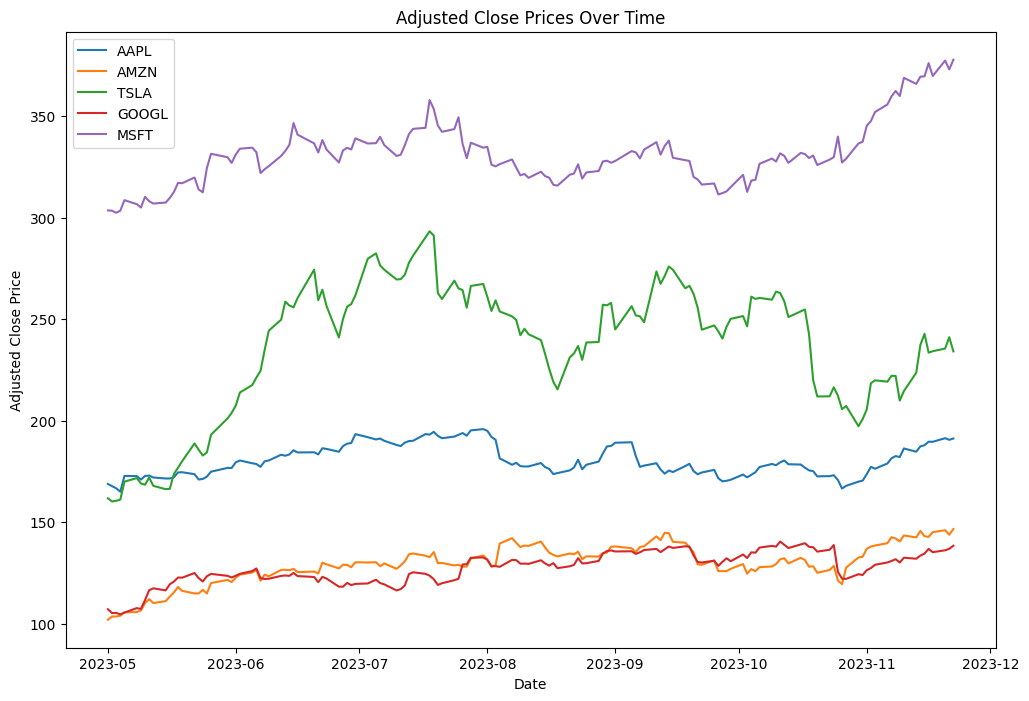

In [96]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 8))

for ticker in tickers:
    plt.plot(data.index, data['Adj Close'][ticker], label=ticker)

plt.title('Adjusted Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

**RISK ANALYSIS ATTEMPT**

In [97]:
# Calculate volatility
daily_returns = data['Adj Close'].pct_change()
volatility = daily_returns.std()

# Calculate Sharpe ratio
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)


confidence_level = 0.95
var = norm.ppf(1 - confidence_level, daily_returns.mean(), daily_returns.std())

cumulative_returns = (1 + daily_returns).cumprod()
peak = cumulative_returns.cummax()
drawdown = (cumulative_returns - peak) / peak
max_drawdown = drawdown.min()


Visualisation:

IndexError: index 1682899200000000000 is out of bounds for axis 0 with size 144

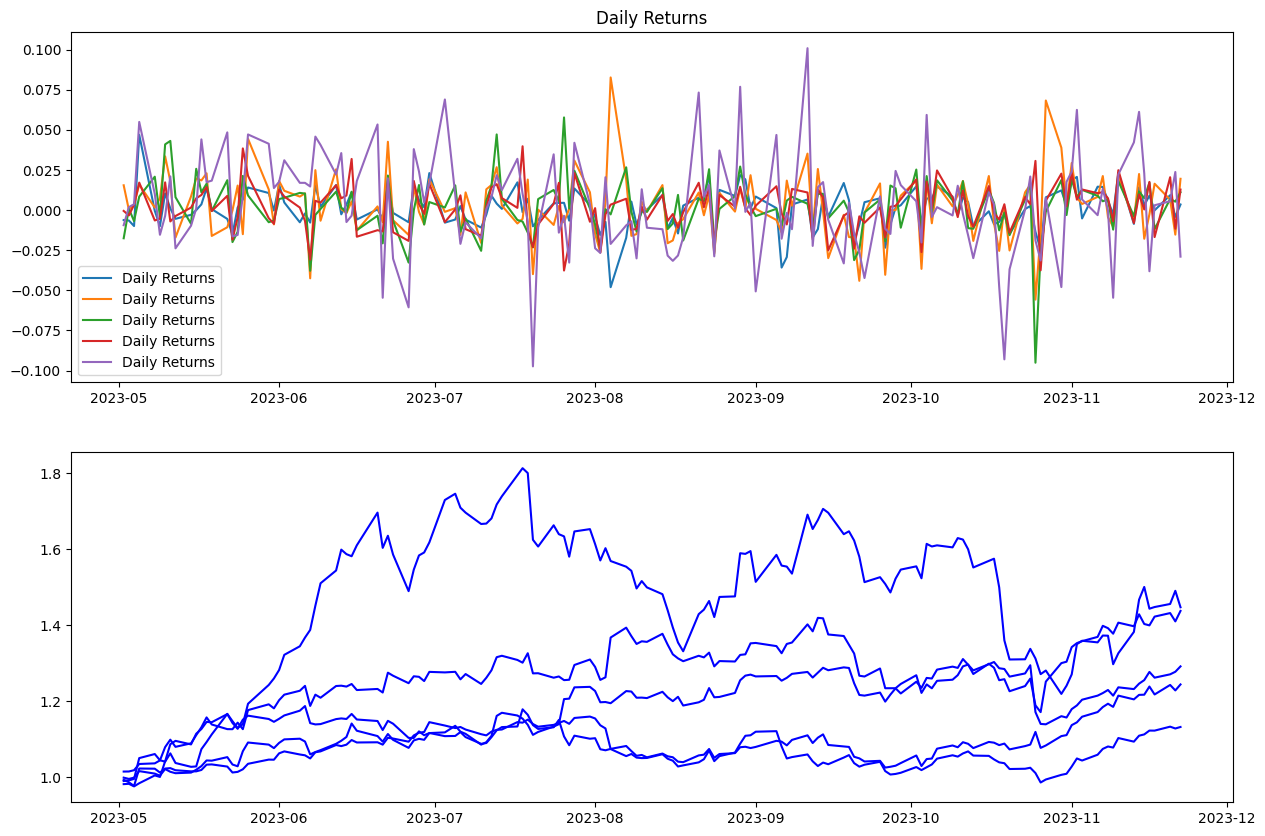

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming daily_returns, cumulative_returns, and max_drawdown are already defined

# Increase the figure size
plt.figure(figsize=(15, 10))

# Plotting daily returns
plt.subplot(2, 1, 1)
plt.plot(daily_returns, label='Daily Returns')
plt.title('Daily Returns')
plt.legend()

# Plotting cumulative returns and highlighting maximum drawdown
plt.subplot(2, 1, 2)
plt.plot(cumulative_returns, label='Cumulative Returns', color='blue')

# Create an array of zeros with the same length as cumulative_returns
zero_line = np.zeros_like(cumulative_returns)

# Highlighting maximum drawdown
drawdown_threshold = 0.05  # Set a threshold for drawdown visibility
highlight_drawdown = drawdown[drawdown < -drawdown_threshold]

# Convert indices to integer values
highlight_drawdown_indices = highlight_drawdown.index.astype(int)

plt.fill_between(
    x=highlight_drawdown_indices,
    y1=zero_line[highlight_drawdown_indices],
    y2=cumulative_returns[highlight_drawdown_indices],
    color='red', alpha=0.3, label='Drawdown'
)

# Increase the figure size
plt.figure(figsize=(20,10))

plt.title('Cumulative Returns with Maximum Drawdown')
plt.legend()
plt.tight_layout()
plt.show()


Portfolio Construction:


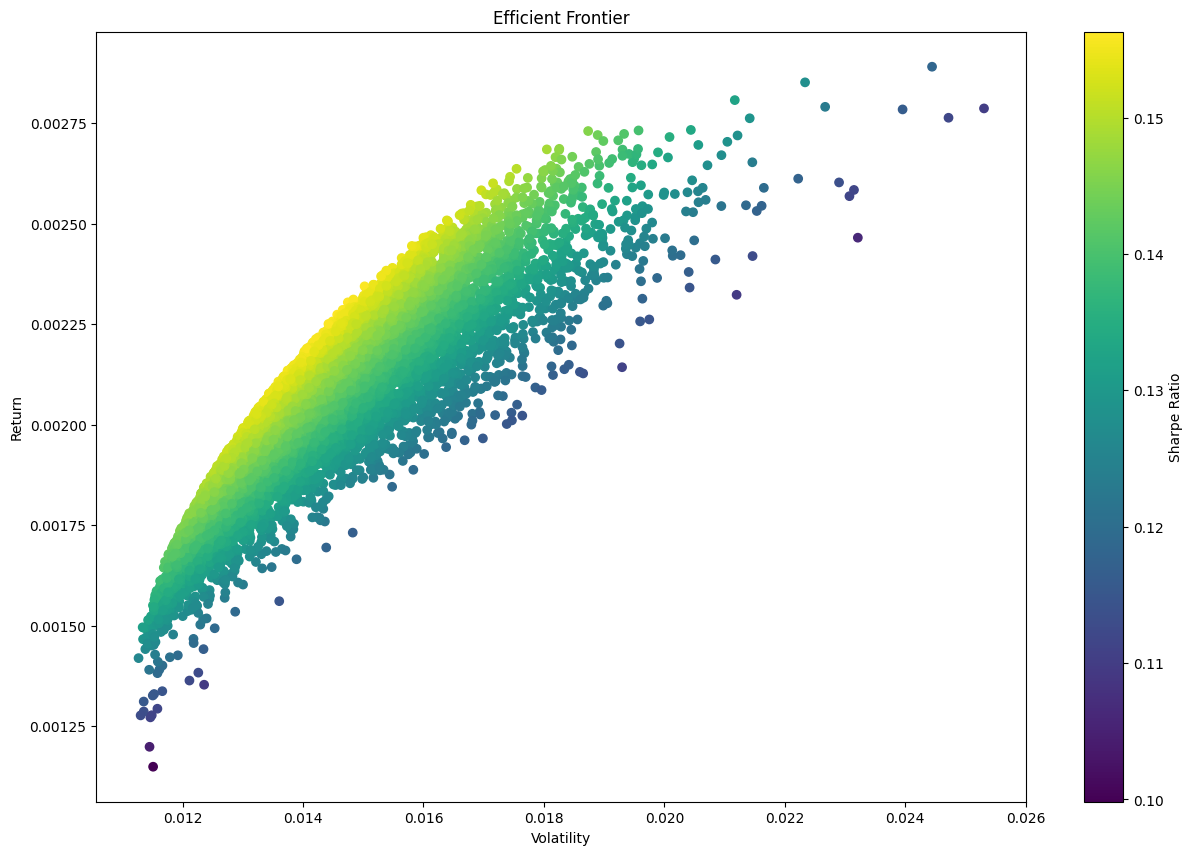

In [99]:
# Calculate mean returns
mean_returns = daily_returns.mean()

# Calculate covariance matrix
cov_matrix = daily_returns.cov()

from scipy.optimize import minimize

def objective(weights):
    # Objective function to minimize - negative Sharpe ratio
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -portfolio_return / portfolio_volatility

# Constraints: weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds: weights between 0 and 1
bounds = tuple((0, 1) for asset in range(len(tickers)))

# Initial weights
initial_weights = [1. / len(tickers) for _ in range(len(tickers))]

# Optimize
result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = result.x

#---------------------------------------------------------------------------------------------------------------------------------------------------------------

# Simulate portfolios for the efficient frontier
port_returns = []
port_volatilities = []

for _ in range(10000):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

    # Calculate portfolio return and volatility
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Append to lists
    port_returns.append(portfolio_return)
    port_volatilities.append(portfolio_volatility)

# Convert lists to NumPy arrays
port_returns = np.array(port_returns)
port_volatilities = np.array(port_volatilities)


# Increase the figure size
plt.figure(figsize=(15, 10))

# Plot the efficient frontier
plt.scatter(port_volatilities, port_returns, c=port_returns/port_volatilities, marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.colorbar(label='Sharpe Ratio')
plt.show()


**Performance Metric**

In [100]:
# Calculate Total Return, Annualized Return, and Maximum Drawdown:

# Total Return
total_return = cumulative_returns.iloc[-1] - 1

# Annualized Return
annualized_return = (1 + total_return) ** (252 / len(cumulative_returns.index.year.unique())) - 1

# Maximum Drawdown
max_drawdown = drawdown.min()

print("Total Return:", total_return)
print("Annualized Return:", annualized_return)
print("Maximum Drawdown:", max_drawdown)


Total Return: AAPL     0.132650
AMZN     0.437629
GOOGL    0.291884
MSFT     0.244430
TSLA     0.447259
Name: 2023-11-22 00:00:00, dtype: float64
Annualized Return: AAPL     4.286275e+13
AMZN     5.333007e+39
GOOGL    1.067486e+28
MSFT     8.561232e+23
TSLA     2.868763e+40
Name: 2023-11-22 00:00:00, dtype: float64
Maximum Drawdown: AAPL    -0.149324
AMZN    -0.174525
GOOGL   -0.130772
MSFT    -0.129876
TSLA    -0.327197
dtype: float64


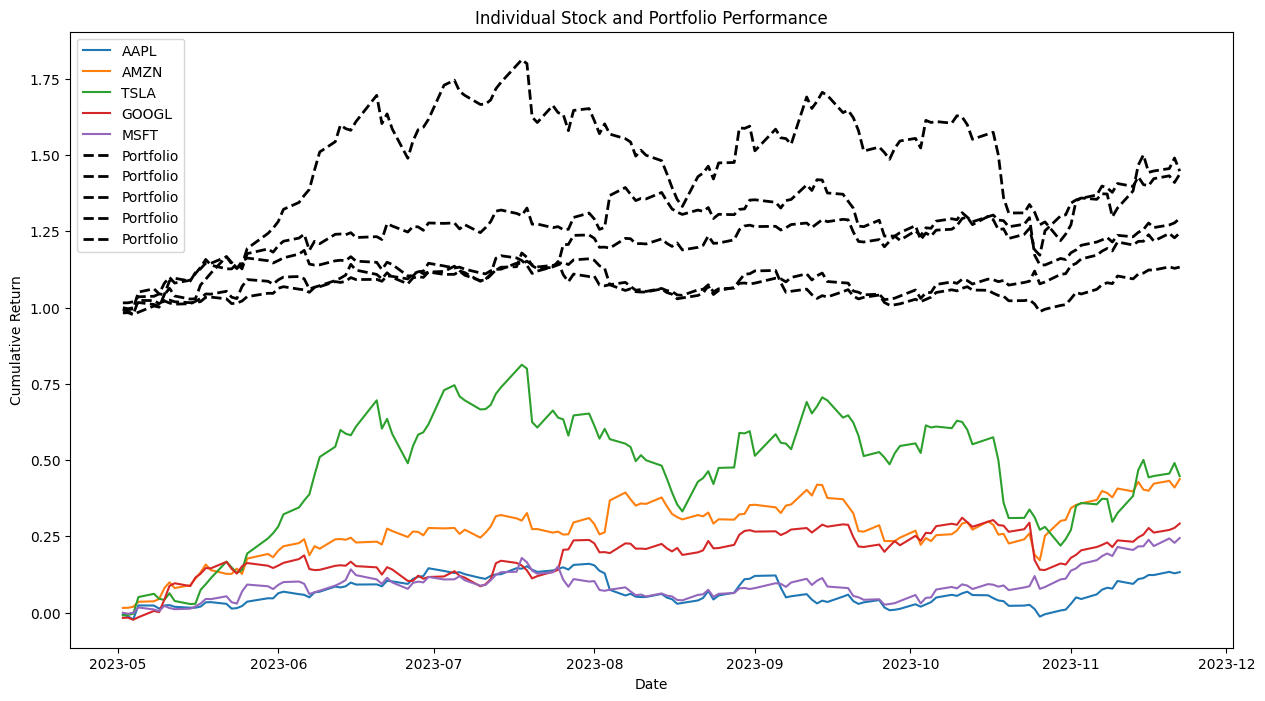

In [101]:
# Assuming individual stock prices are stored in a DataFrame named 'data'

# Calculate individual stock returns
individual_stock_returns = data['Adj Close'].pct_change()

# Calculate individual stock total returns
individual_stock_total_returns = (1 + individual_stock_returns).cumprod() - 1

# Compare individual stock and portfolio performance
plt.figure(figsize=(15, 8))

# Plot individual stock total returns
for stock in tickers:
    plt.plot(individual_stock_total_returns.index, individual_stock_total_returns[stock], label=stock)

# Plot portfolio cumulative returns
plt.plot(cumulative_returns.index, cumulative_returns, label='Portfolio', linestyle='--', linewidth=2, color='black')

plt.title('Individual Stock and Portfolio Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()



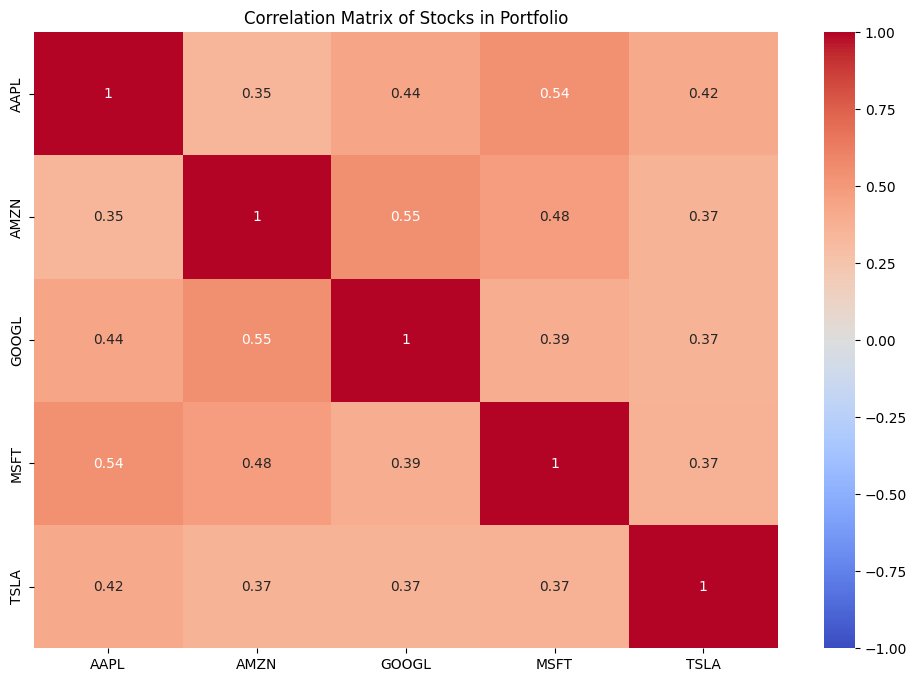

In [102]:
# Calculate correlation matrix
correlation_matrix = daily_returns.corr()

# Display heatmap of the correlation matrix
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Stocks in Portfolio')
plt.show()


In [90]:
# Calculate rolling correlation
rolling_correlation = daily_returns.rolling(window=30).corr()

# Select two stocks for illustration
stock1 = 'AAPL'
stock2 = 'GOOGL'

# Plot rolling correlation between two stocks
plt.figure(figsize=(15, 8))
plt.plot(rolling_correlation[stock1][stock2], label=f'{stock1} vs {stock2}')

plt.title(f'Rolling Correlation between {stock1} and {stock2}')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.show()


KeyError: 'GOOGL'

<Figure size 1500x800 with 0 Axes>